# Basic functionality of LensCharm

1. **Specify the model**
    1. **Source model**
        1. Specify the space
        2. Specify the source model

    2. **Lens model**
        1. Specify the space
        2. The lens model

3. **Connect source and lens model**

4. **Load the data**

5. **Reconstruction of the data**

# 1. Specify the model

### Priors of the model

In LensCharm a model is always specified with priors for the parameters of the model.
The priors are set by a config dictionary which holds the prior settings for each parameter.

After the model is instanciated, we can always obtain the 
- config by ```model.config```
- latent space by ```model.domain```

### Model Choices

In LensCharm one can choose to model the light and convergence profile by either a parametric, nonparametric, or hybrid model.

The **parametric models** include
- Gaussian
- PIE
- dPIE
- SPL
- CPL

The available **nonparametric model** are
- Matern_field
- Correlated_field

A **hybrid model** is a combination of a parametric with a nonparametric model. These can be defined to be 
- multiplicative (default)
- additive 

### 1.1. Source model

First, we specify the source model defined on the source plane which is a regular grid space.
In this tutorial, we define a hybrid source light model which is a Gaussian modified (perturbed) by a multiplicative Matern kernel field.

In [1]:
import jax 
jax.config.update("jax_platform_name", "cpu")

# Build the source model
from charm_lensing.spaces import Space
from charm_lensing.models import build_hybrid_model

# Define source space 
source_space = Space(shape=(128,)*2, distances=0.025, space_key='source')

light_cfg = dict(
    mean=dict(
        gaussian=dict(
            center=dict(
                distribution='normal',
                mean=[0., 0.2],
                sigma=0.05
            ),
            covariance=dict(
                distribution='log_normal',
                mean=0.5,
                sigma=0.05,
            ),
            off_diagonal=dict(
                distribution='normal',
                mean=0.0,
                sigma=5.0
            )
        )
    ),
    perturbations=dict(
        matern=dict(
            amplitude=dict(
                offset_mean=4.,
                offset_std=[1.e-1, 1.e-2]
            ),
            fluctuations=dict(
                scale=[2.0, 3e-1],
                cutoff=[0.1, 0.01],
                loglogslope=[-4.0, 0.5]
            )
        )
    )
)
source_model = build_hybrid_model(
    source_space,
    'light',
    light_cfg,
)

### 1.2. Lens model

Next, we setup the lens model which is also defined on a regular 'lens' grid.
Furthermore, we define the lens mass model by a parametric PIE.

In [2]:
from charm_lensing.spaces import Space
from charm_lensing.models import build_hybrid_model

# The extend factor is needed to mitigate the effect of the periodic 
# boundary conditions for the evaluation of the deflection angle field 
# from a hybrid lens mass model
lens_space = Space(shape=(64,)*2, distances=0.05, space_key='lens', extend_factor=2.0)  

lens_cfg = dict(
    mean=dict(
        pie=dict(
            b=dict(
                distribution='lognormal',
                mean=0.5,
                sigma=0.05
            ),
            rs=dict(
                distribution='uniform',
                min=1.0e-12,
                max=1.0e-2
            ),
            center=dict(
                distribution='normal',
                mean=0.0,
                sigma=0.05
            ),
            q=dict(
                distribution='uniform',
                min=1.0,
                max=1.1
            ),
            theta=dict(
                distribution='normal',
                mean=0.0,
                sigma=10
            )
        )
    )
)

lens_model = build_hybrid_model(
    lens_space.extend(),
    'mass',
    lens_cfg,
)

## Visualize prior samples from the Model

In [3]:
def plot_samples(model, N, key, logplot=False):
    import nifty8 as ift
    import matplotlib.pyplot as plt
    from charm_lensing.plotting import find_best_grid
    from matplotlib.colors import LogNorm

    ny, nx = find_best_grid(N)
    fig, axes = plt.subplots(nx, ny, figsize=(ny*3, nx*3))
    axes = axes.flatten()
    for ax in axes:
        key, subkey = random.split(key)
        rp = ift.re.random_like(subkey, model.domain)
        im = ax.imshow(model(rp), origin='lower', norm=LogNorm() if logplot else None)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()

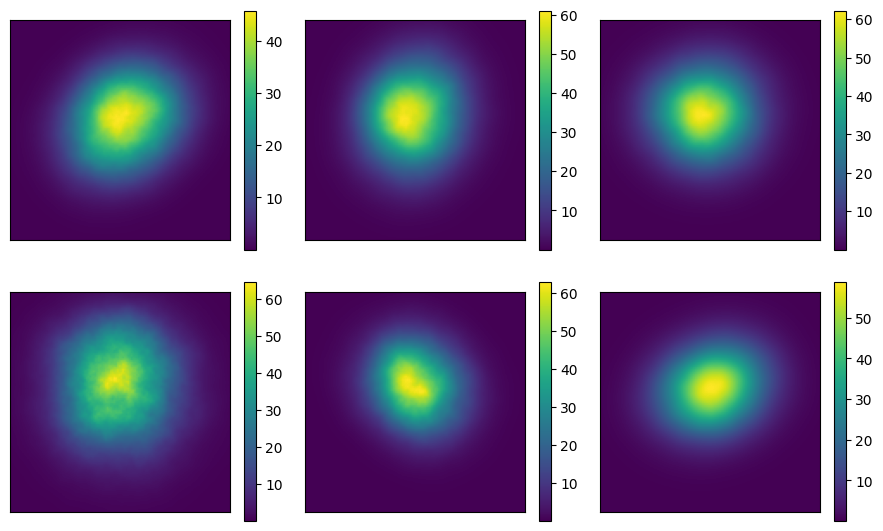

In [4]:
# Source Model

import jax.random as random
key = random.PRNGKey(40)
key, plot_key = random.split(key)
plot_samples(source_model, 6, plot_key)

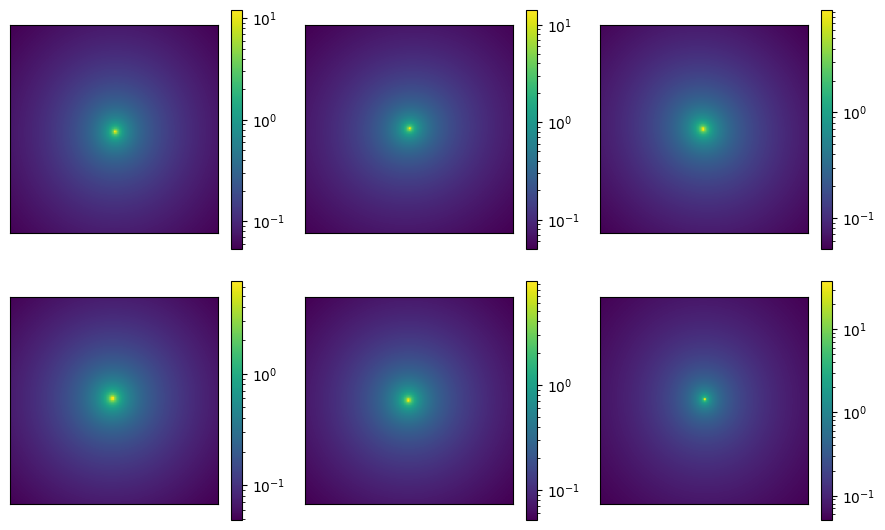

In [5]:
# Lens Model
key = random.PRNGKey(42)
key, plot_key = random.split(key)
plot_samples(lens_model, 6, plot_key, logplot=True)

# 2. Connect source light with lens

The ray-casting of the source light through the lens mass is, in LensCharm, performed by a linear interpolation.
The linear interpolation projection is build via a helper function.

In [6]:
from charm_lensing.projection_operator import build_projection_operator
source_projector = build_projection_operator(lens_space, source_space)

Using bilinear interpolation


Next, we have to connect the source light to the lens plane. 
This is accomplished by the `LensSystem` which is a class that expects:
- lens_plane_model, of type `SpaceModel`
- source_plane_model, of type `SpaceModel`
- source_projection which is the linear_projection operator we have just build.

The `SpaceModel` is a 'container' class which can contain:
- light_model, of type `Model` or `None` (default)
- convergence_model, of type `Model` or `None` (default)

In [7]:
from charm_lensing.build_lens_system import LensSystem
from charm_lensing.space_model import SpaceModel

lens_plane_model = SpaceModel(lens_space, convergence_model=lens_model)
source_plane_model = SpaceModel(source_space, light_model=source_model)

lens_system = LensSystem(
    lens_plane_model=lens_plane_model,
    source_plane_model=source_plane_model,
    source_projector=source_projector
)

# 3. Load the data

Next, we need to:
1. Load the data
2. Connect the data to the sky model, via the likelihood


## Download example data
1. Example data for this notebook can be downloaded at [data](https://datashare.mpcdf.mpg.de/s/dASgBbTOjHb1B92).
2. Move the data in the `data/` folder.

In [8]:
# 1. Load the data and the likelihood
from charm_lensing.data_loader import RealDataLoadingStrategy


data_config = dict(
    data=dict(
        files=dict(
            likelihood_01=dict(
                noise_scale=10.,
                pixel_size=0.05,
                psf_path='../data/demo_01/psf.fits',
                data_path='../data/demo_01/data.fits',
                source_path='../data/demo_01/source.fits'
            )
        )
    )
)
likelihood, data = RealDataLoadingStrategy(
    data_config,
    'sky',
    lens_system.lens_plane_model.space
)



/Users/matteani/PycharmProjects/nifty/src/re/model.py:160: UserWarning: drawing white parameters;
to silence this warning, overload the `init` method
  warn(msg)


In [9]:
# 2. Connect the likelihood to the sky model
from charm_lensing.nifty_connect import connect_likelihood_to_model

like_parametric = connect_likelihood_to_model(
    likelihood,
    lens_system.get_forward_model_parametric()
)


# 4. Reconstruction of the data 

Lastly, we reconstruct the data. 
This step is equivalent to a optimization of the model parameters.


In the context of MGVI and geoVI, this means to obtain samples and to perform a KL minimization.
Samples that fit the posterior distribution at the current mean position are obtained by minimizing in a
- linear fashion (their optimization is set by the `lin_` keywords) and in a 
- nonlinear fashion (their optimization is set by the `nonlin_` keywords),

we will set these in the following. 
When employing `nonlin` samples the samples are first obtained linearly and then updated to be nonlinear.
The `mode` keyword specifies the sample type.

For more information about posterior inference, refer to
[Nifty User Guide](https://ift.pages.mpcdf.de/nifty/user/index.html)

In [10]:
import nifty8 as ift
from charm_lensing import minimization_parser
from charm_lensing.plotting import plot_check_factory, nifty_plotting_wrapper, plot_check_factory
from numpy import random

random.seed(42)
ift.random.push_sseq_from_seed(42)


parametric_minimization = dict(
    n_total_iterations=9,
    kl_mini=dict(name='KL', 
                 switches=[0, 5],
                 kl_deltaE=[0.01, 0.0001], 
                 kl_maxiter=[10, 15]),

    samples=dict(
        switches=[0, 5],
        n_samples=[5, 7],
        name=['lin', 'nonlin'],
        mode=['linear_sample', 'nonlinear_sample'],
        lin_deltaE=[0.01, 0.0001],
        lin_maxiter=[50, 100],
        lin_convergence_level=2,
        nonlin_deltaE=0.01,
        nonlin_maxiter=7,
        nonlin_convergence_level=2,
    )
)

output = './output/demo_01'
resume = False


# parametric minimization
samples = ift.optimize_kl(
    like_parametric,
    parametric_minimization.get('n_total_iterations'),
    minimization_parser.n_samples_factory(parametric_minimization),
    minimization_parser.minimizer_factory(parametric_minimization),
    minimization_parser.linear_sampling_factory(parametric_minimization),
    minimization_parser.nonlinear_sampling_factory(parametric_minimization),
    output_directory=output,
    initial_position=None,
    resume=resume,
    inspect_callback=nifty_plotting_wrapper(
        plot_check_factory(
            outputdir=output,
            data=data,
            cfg=dict(mock=True, plotting_options=dict(mock_data=True, log_data=False)),
            lens_system=lens_system,
            parametric=True,
            min_iterations=0,)
    ))

lin: dE=1.0e-02, cl=2, il=50: Iteration #0 energy=-3.628614E+03 diff=3.628614E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #1 energy=-5.566263E+03 diff=1.937649E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #2 energy=-7.140737E+03 diff=1.574474E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #3 energy=-7.524493E+03 diff=3.837567E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #4 energy=-7.922114E+03 diff=3.976209E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #5 energy=-7.933125E+03 diff=1.101119E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #6 energy=-8.000526E+03 diff=6.740094E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #7 energy=-8.009958E+03 diff=9.432203E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #8 energy=-8.023932E+03 diff=1.397373E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #9 energy=-8.051111E+03 diff=2.717907E+01 

Plotting iteration 0 in ./output/demo_01



lin: dE=1.0e-02, cl=2, il=50: Iteration #0 energy=4.592499E+04 diff=4.592499E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #1 energy=3.863923E+01 diff=4.588635E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #2 energy=-4.847028E+03 diff=4.885668E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #3 energy=-7.161543E+03 diff=2.314515E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #4 energy=-7.815252E+03 diff=6.537091E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #5 energy=-7.987018E+03 diff=1.717658E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #6 energy=-8.122896E+03 diff=1.358781E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #7 energy=-8.154624E+03 diff=3.172839E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #8 energy=-8.186442E+03 diff=3.181784E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #9 energy=-8.215994E+03 diff=2.955147E+01 cr

Plotting done


lin: dE=1.0e-02, cl=2, il=50: Iteration #22 energy=-8.313728E+03 diff=6.916296E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #23 energy=-8.317865E+03 diff=4.137089E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #24 energy=-8.319968E+03 diff=2.102059E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #25 energy=-8.319973E+03 diff=5.900786E-03 crit=1.0E-02 clvl=1
lin: dE=1.0e-02, cl=2, il=50: Iteration #26 energy=-8.320175E+03 diff=2.020043E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #27 energy=-8.321358E+03 diff=1.182545E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #28 energy=-8.321387E+03 diff=2.872150E-02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #29 energy=-8.321964E+03 diff=5.774355E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #30 energy=-8.321969E+03 diff=4.892671E-03 crit=1.0E-02 clvl=1
lin: dE=1.0e-02, cl=2, il=50: Iteration #31 energy=-8.321979E+03 diff=9.9

Plotting iteration 1 in ./output/demo_01



lin: dE=1.0e-02, cl=2, il=50: Iteration #0 energy=9.249252E+03 diff=9.249252E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #1 energy=2.466809E+03 diff=6.782443E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #2 energy=1.269090E+03 diff=1.197719E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #3 energy=-4.835911E+03 diff=6.105000E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #4 energy=-6.672227E+03 diff=1.836317E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #5 energy=-7.334238E+03 diff=6.620103E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #6 energy=-7.710884E+03 diff=3.766465E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #7 energy=-7.791390E+03 diff=8.050630E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #8 energy=-7.877731E+03 diff=8.634041E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #9 energy=-7.963004E+03 diff=8.527283E+01 cri

Plotting done


lin: dE=1.0e-02, cl=2, il=50: Iteration #23 energy=-8.251534E+03 diff=7.164650E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #24 energy=-8.257195E+03 diff=5.660247E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #25 energy=-8.261399E+03 diff=4.204283E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #26 energy=-8.261417E+03 diff=1.842075E-02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #27 energy=-8.261851E+03 diff=4.338270E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #28 energy=-8.266460E+03 diff=4.608736E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #29 energy=-8.266711E+03 diff=2.508147E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #30 energy=-8.270073E+03 diff=3.362246E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #31 energy=-8.270230E+03 diff=1.574153E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #32 energy=-8.270404E+03 diff=1.7

Plotting iteration 2 in ./output/demo_01



lin: dE=1.0e-02, cl=2, il=50: Iteration #0 energy=1.701056E+04 diff=1.701056E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #1 energy=8.481870E+02 diff=1.616237E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #2 energy=-1.869618E+03 diff=2.717805E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #3 energy=-5.229341E+03 diff=3.359723E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #4 energy=-6.403053E+03 diff=1.173712E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #5 energy=-7.176602E+03 diff=7.735494E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #6 energy=-7.368182E+03 diff=1.915797E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #7 energy=-7.552665E+03 diff=1.844825E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #8 energy=-7.680770E+03 diff=1.281052E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #9 energy=-7.743540E+03 diff=6.276996E+01 cr

Plotting done


lin: dE=1.0e-02, cl=2, il=50: Iteration #22 energy=-8.175333E+03 diff=1.973477E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #23 energy=-8.175658E+03 diff=3.255837E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #24 energy=-8.181705E+03 diff=6.046715E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #25 energy=-8.181877E+03 diff=1.720687E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #26 energy=-8.186602E+03 diff=4.724999E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #27 energy=-8.190653E+03 diff=4.050284E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #28 energy=-8.196320E+03 diff=5.667163E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #29 energy=-8.197731E+03 diff=1.411317E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #30 energy=-8.198274E+03 diff=5.432467E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #31 energy=-8.199760E+03 diff=1.4

Plotting iteration 3 in ./output/demo_01



lin: dE=1.0e-02, cl=2, il=50: Iteration #0 energy=8.082838E+04 diff=8.082838E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #1 energy=2.699388E+04 diff=5.383450E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #2 energy=-6.864297E+02 diff=2.768031E+04 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #3 energy=-4.510211E+03 diff=3.823781E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #4 energy=-5.806912E+03 diff=1.296700E+03 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #5 energy=-6.404975E+03 diff=5.980636E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #6 energy=-7.238417E+03 diff=8.334419E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #7 energy=-7.537698E+03 diff=2.992808E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #8 energy=-7.826550E+03 diff=2.888518E+02 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #9 energy=-7.903146E+03 diff=7.659605E+01 cr

Plotting done


lin: dE=1.0e-02, cl=2, il=50: Iteration #24 energy=-8.330637E+03 diff=1.479089E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #25 energy=-8.341918E+03 diff=1.128114E+01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #26 energy=-8.342406E+03 diff=4.876916E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #27 energy=-8.343641E+03 diff=1.235022E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #28 energy=-8.349570E+03 diff=5.928804E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #29 energy=-8.351225E+03 diff=1.655441E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #30 energy=-8.353030E+03 diff=1.804137E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #31 energy=-8.354151E+03 diff=1.121897E+00 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #32 energy=-8.354481E+03 diff=3.295817E-01 crit=1.0E-02 clvl=0
lin: dE=1.0e-02, cl=2, il=50: Iteration #33 energy=-8.357072E+03 diff=2.5

Plotting iteration 4 in ./output/demo_01



nonlin: dE=1.0e-04, cl=2, il=100: Iteration #0 energy=1.180458E+04 diff=1.180458E+04 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #1 energy=6.915664E+03 diff=4.888911E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #2 energy=-2.734725E+03 diff=9.650389E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #3 energy=-5.470552E+03 diff=2.735827E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #4 energy=-6.753355E+03 diff=1.282802E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #5 energy=-7.147348E+03 diff=3.939937E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #6 energy=-7.295427E+03 diff=1.480783E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #7 energy=-7.418625E+03 diff=1.231987E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #8 energy=-7.496238E+03 diff=7.761252E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #9 e

Plotting done


nonlin: dE=1.0e-04, cl=2, il=100: Iteration #23 energy=-8.201819E+03 diff=1.164811E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #24 energy=-8.202763E+03 diff=9.439887E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #25 energy=-8.216754E+03 diff=1.399035E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #26 energy=-8.226202E+03 diff=9.448165E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #27 energy=-8.226357E+03 diff=1.557130E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #28 energy=-8.226999E+03 diff=6.415744E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #29 energy=-8.233528E+03 diff=6.529025E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #30 energy=-8.234149E+03 diff=6.213050E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #31 energy=-8.235018E+03 diff=8.690946E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Ite

Plotting iteration 5 in ./output/demo_01



nonlin: dE=1.0e-04, cl=2, il=100: Iteration #0 energy=5.722402E+03 diff=5.722402E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #1 energy=2.051059E+03 diff=3.671343E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #2 energy=-2.885683E+03 diff=4.936742E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #3 energy=-4.605151E+03 diff=1.719468E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #4 energy=-5.462498E+03 diff=8.573478E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #5 energy=-6.049812E+03 diff=5.873132E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #6 energy=-6.836283E+03 diff=7.864716E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #7 energy=-7.039436E+03 diff=2.031528E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #8 energy=-7.198285E+03 diff=1.588489E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #9 e

Plotting done


nonlin: dE=1.0e-04, cl=2, il=100: Iteration #23 energy=-8.098529E+03 diff=2.080118E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #24 energy=-8.115776E+03 diff=1.724751E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #25 energy=-8.118168E+03 diff=2.391139E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #26 energy=-8.121265E+03 diff=3.097845E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #27 energy=-8.121940E+03 diff=6.741476E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #28 energy=-8.125517E+03 diff=3.577357E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #29 energy=-8.134875E+03 diff=9.357621E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #30 energy=-8.138362E+03 diff=3.487650E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #31 energy=-8.140037E+03 diff=1.674619E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Ite

Plotting iteration 6 in ./output/demo_01



nonlin: dE=1.0e-04, cl=2, il=100: Iteration #0 energy=2.512969E+04 diff=2.512969E+04 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #1 energy=6.705241E+03 diff=1.842445E+04 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #2 energy=-2.087778E+03 diff=8.793020E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #3 energy=-4.272947E+03 diff=2.185169E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #4 energy=-5.802413E+03 diff=1.529466E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #5 energy=-6.457492E+03 diff=6.550783E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #6 energy=-6.868106E+03 diff=4.106141E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #7 energy=-7.072720E+03 diff=2.046141E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #8 energy=-7.274113E+03 diff=2.013932E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #9 e

Plotting done


nonlin: dE=1.0e-04, cl=2, il=100: Iteration #20 energy=-8.070382E+03 diff=1.590399E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #21 energy=-8.092084E+03 diff=2.170216E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #22 energy=-8.095031E+03 diff=2.947230E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #23 energy=-8.112697E+03 diff=1.766623E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #24 energy=-8.121070E+03 diff=8.372009E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #25 energy=-8.129406E+03 diff=8.336071E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #26 energy=-8.129512E+03 diff=1.067277E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #27 energy=-8.135896E+03 diff=6.384068E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #28 energy=-8.142829E+03 diff=6.932846E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Ite

Plotting iteration 7 in ./output/demo_01



nonlin: dE=1.0e-04, cl=2, il=100: Iteration #0 energy=8.771786E+05 diff=8.771786E+05 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #1 energy=2.150578E+04 diff=8.556728E+05 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #2 energy=1.197979E+02 diff=2.138598E+04 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #3 energy=-4.096383E+03 diff=4.216181E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #4 energy=-6.042478E+03 diff=1.946095E+03 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #5 energy=-6.550517E+03 diff=5.080389E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #6 energy=-7.195360E+03 diff=6.448429E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #7 energy=-7.293788E+03 diff=9.842846E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #8 energy=-7.480134E+03 diff=1.863464E+02 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #9 en

Plotting done


nonlin: dE=1.0e-04, cl=2, il=100: Iteration #22 energy=-8.159878E+03 diff=8.406352E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #23 energy=-8.173262E+03 diff=1.338404E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #24 energy=-8.185033E+03 diff=1.177031E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #25 energy=-8.185856E+03 diff=8.237026E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #26 energy=-8.189712E+03 diff=3.855385E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #27 energy=-8.192428E+03 diff=2.716306E+00 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #28 energy=-8.203525E+03 diff=1.109662E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #29 energy=-8.215330E+03 diff=1.180504E+01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Iteration #30 energy=-8.215647E+03 diff=3.173339E-01 crit=1.0E-04 clvl=0
nonlin: dE=1.0e-04, cl=2, il=100: Ite

Plotting iteration 8 in ./output/demo_01

Plotting done


Plotting iteration 0 in None



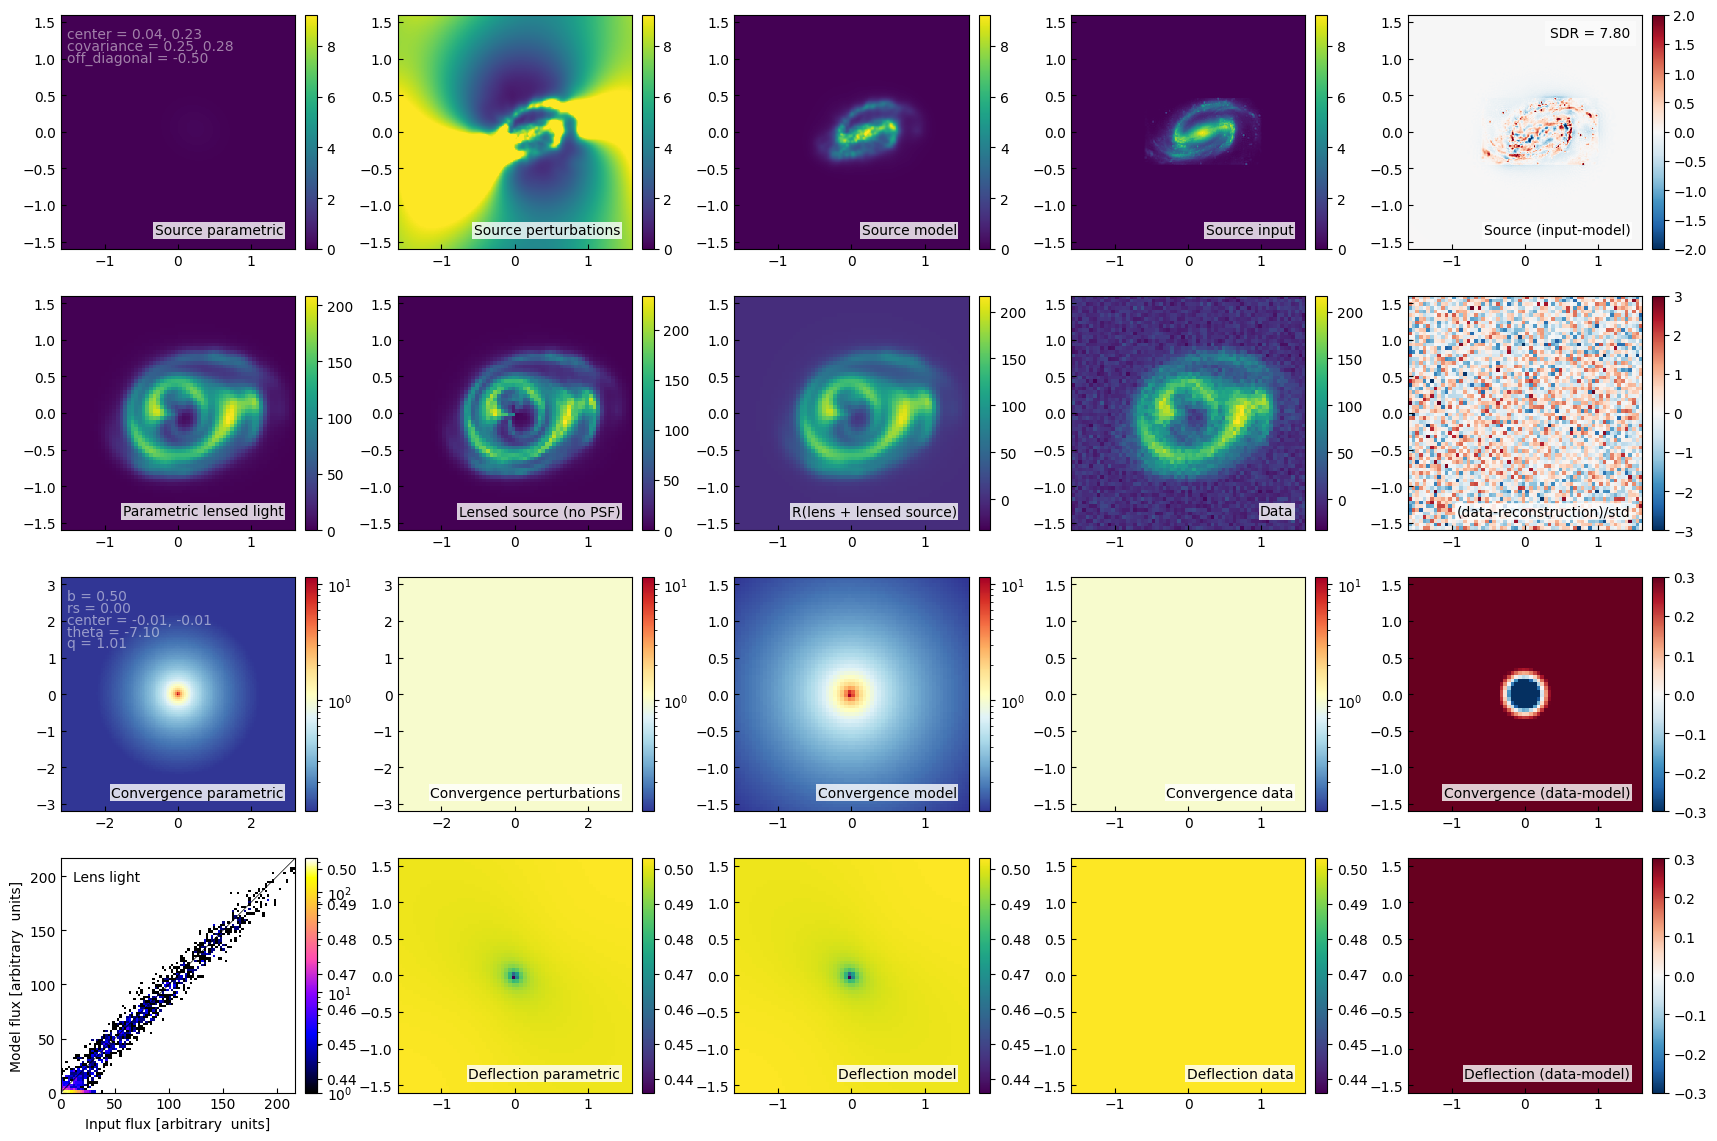

Plotting done


In [11]:
# Plot final result
plot_results = nifty_plotting_wrapper(
        plot_check_factory(
            outputdir=None,
            data=data,
            cfg=dict(mock=True, plotting_options=dict(mock_data=True, log_data=False)),
            lens_system=lens_system,
            parametric=True,
            min_iterations=0,)
    )

plot_results(samples, 0)